


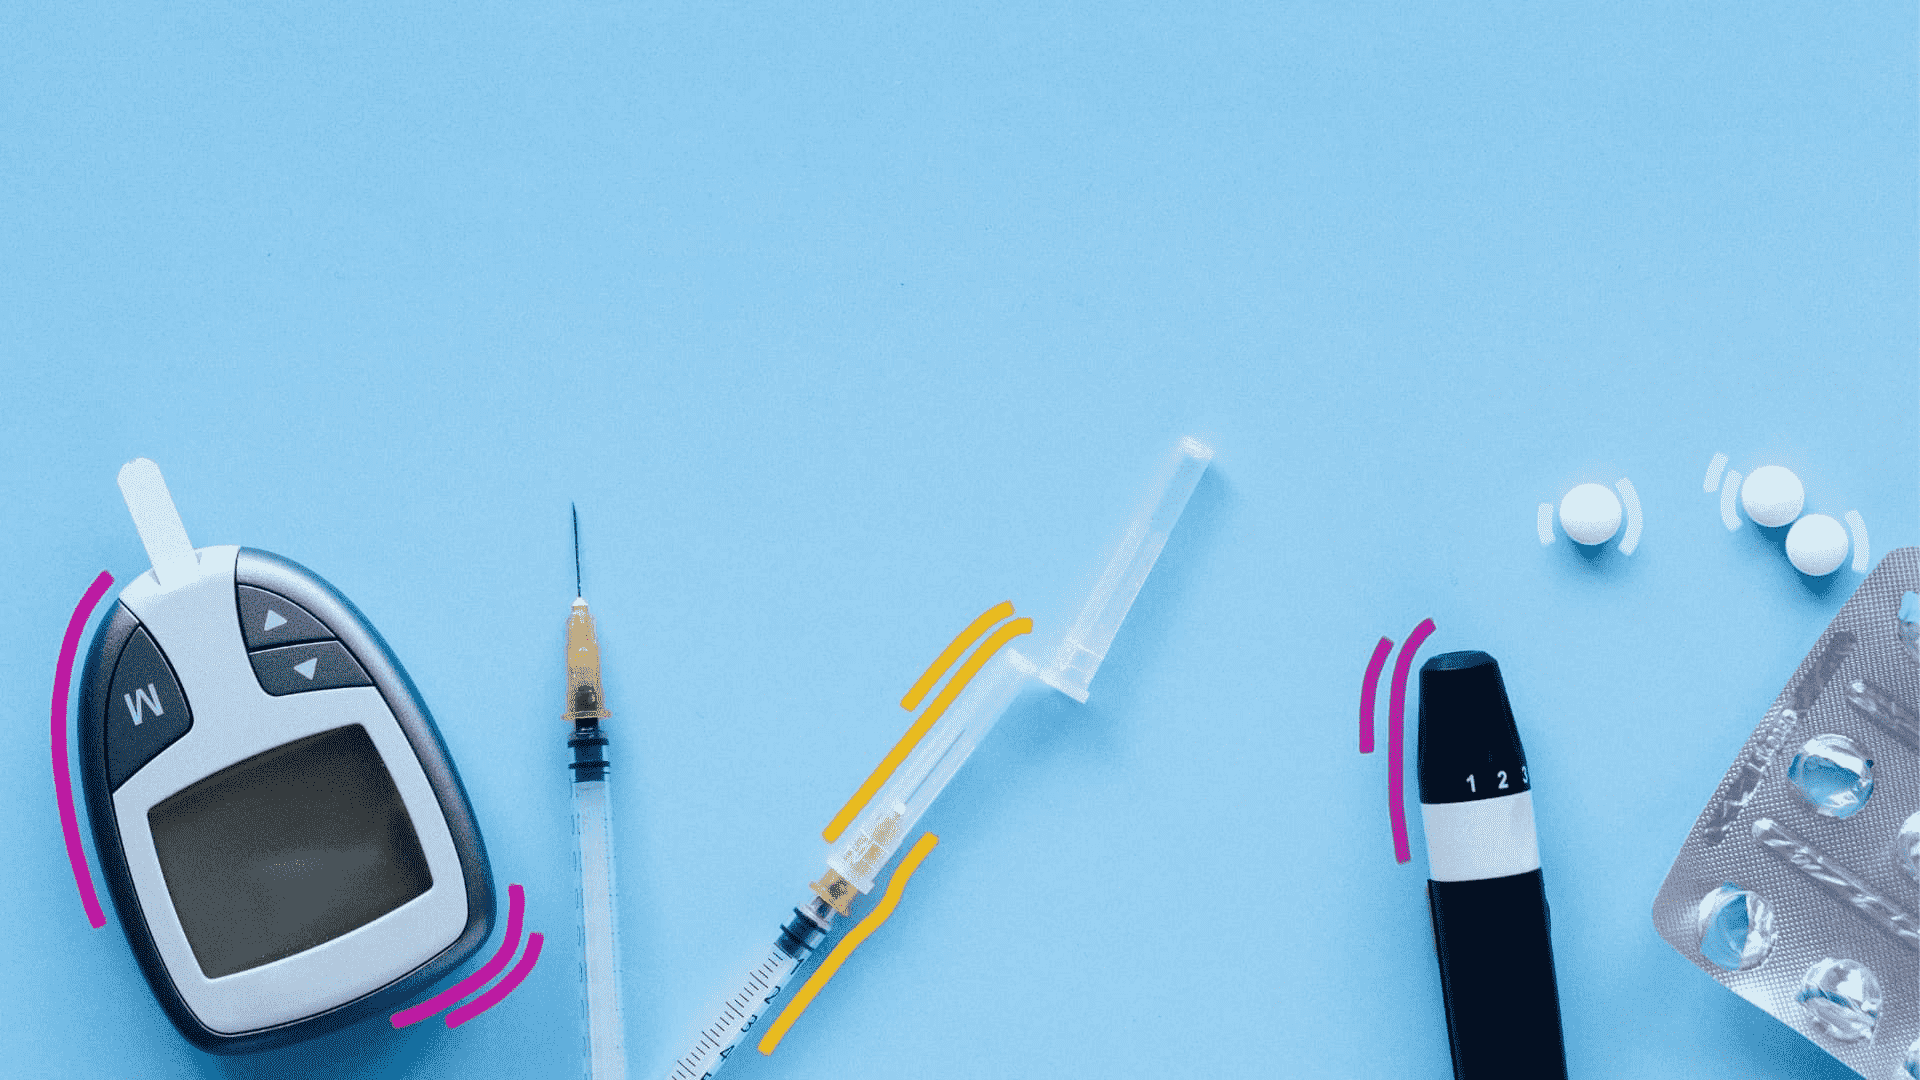
*********************************************

**DİYABET VERİ HİKAYESİ**

Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir.

Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

*********************************************


**DEĞİŞKENLER**
- **Pregnancies**: Hamilelik sayısı
- **Glucose**: Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu
- **Blood Pressure**: Kan Basıncı (Küçük tansiyon) (mm Hg)
- **SkinThickness**: Cilt Kalınlığı
- **Insulin**: 2 saatlik serum insülini (mu U/ml)
- **DiabetesPedigreeFunction**: Fonksiyon (Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu)
- **BMI**: Vücut kitle endeksi
- **Age**: Yaş (yıl)
- **Outcome**: Hastalığa sahip (1) ya da değil (0)

# 1.DATA HAZIRLANMASI

In [1]:
from operator import index
from statistics import quantiles
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime



from pandas.core.common import random_state
from xgboost import XGBClassifier, plot_importance
from pandas import get_dummies



from dask.dataframe.core import quantile
from nltk import accuracy
from pyarrow import binary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier





# Uyarıları kaldırma
import warnings
warnings.simplefilter(action = "ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

## 1.1 Keşifçi Veri Analizi

In [2]:
df = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], dtype='object')

In [6]:
# Kolon isimleri Büyük harflere dönüştürme
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [7]:
df.dtypes

PREGNANCIES                   int64
GLUCOSE                       int64
BLOODPRESSURE                 int64
SKINTHICKNESS                 int64
INSULIN                       int64
BMI                         float64
DIABETESPEDIGREEFUNCTION    float64
AGE                           int64
OUTCOME                       int64
dtype: object

In [8]:
def grap_col_names(dataframe, cat_th = 10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]



    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]



    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]



    print(f"Gözlemler: {dataframe.shape[0]}")
    print(f"Değişkenler: {dataframe.shape[1]}")
    print(f"Kategorik_Değişkenler: {len(cat_cols)}")
    print(f"Numerik_Değişkenler: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"Numerik_görünümlük_Kategoriler: {len(num_but_cat)}")



    return cat_cols, num_cols, cat_but_car

In [9]:
cat_cols, num_cols, cat_but_car = grap_col_names(df)

Gözlemler: 768
Değişkenler: 9
Kategorik_Değişkenler: 1
Numerik_Değişkenler: 8
cat_but_car: 0
Numerik_görünümlük_Kategoriler: 1


In [10]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

,PREGNANCIES
OUTCOME,
0,3.298
1,4.866


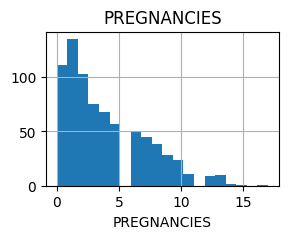

,GLUCOSE
OUTCOME,
0,109.980
1,141.257


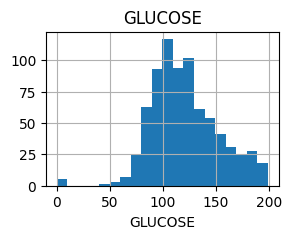

,BLOODPRESSURE
OUTCOME,
0,68.184
1,70.825


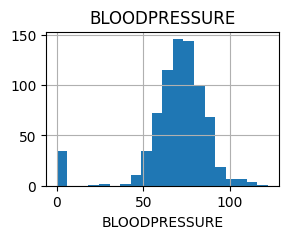

,SKINTHICKNESS
OUTCOME,
0,19.664
1,22.164


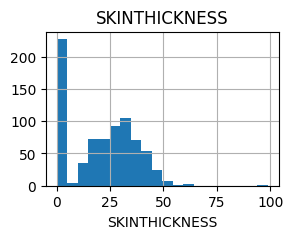

,INSULIN
OUTCOME,
0,68.792
1,100.336


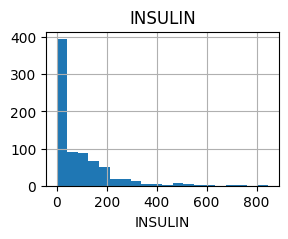

,BMI
OUTCOME,
0,30.304
1,35.143


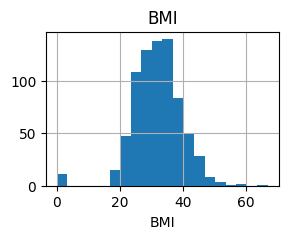

,DIABETESPEDIGREEFUNCTION
OUTCOME,
0,0.430
1,0.550


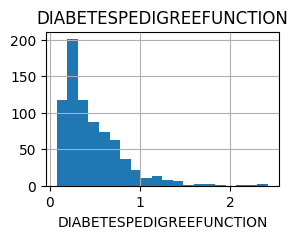

,AGE
OUTCOME,
0,31.190
1,37.067


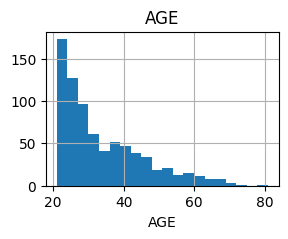

In [11]:
# Hedef değişken analizi yapınız. (Hedef değişkene göre numerik değişken ortalaması)

for col in num_cols:
    display(df.groupby("OUTCOME").agg({col:"mean"}))
    plt.figure(figsize=(3, 2))
    
    df[col].hist(bins=20)
    plt.xlabel(col)
    plt.title(col)
    plt.show()

## 1.2 Outliers (Aykırı değerler saptanması)

In [12]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quantile3 - quantile1
    
    up_limit = quantile3 + interquantile_range * 1.5
    low_limit = quantile1 - interquantile_range * 1.5
    return low_limit, up_limit

In [13]:
for col in num_cols:
    print(col, outlier_thresholds(df, col))

PREGNANCIES (-6.5, 13.5)
GLUCOSE (37.125, 202.125)
BLOODPRESSURE (35.0, 107.0)
SKINTHICKNESS (-48.0, 80.0)
INSULIN (-190.875, 318.125)
BMI (13.35, 50.550000000000004)
DIABETESPEDIGREEFUNCTION (-0.32999999999999996, 1.2)
AGE (-1.5, 66.5)


In [14]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    
    if dataframe[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit)].any(axis = None):
        return True
    else:
        return False

In [15]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES True
GLUCOSE True
BLOODPRESSURE True
SKINTHICKNESS True
INSULIN True
BMI True
DIABETESPEDIGREEFUNCTION True
AGE True


In [16]:
def replace_with_thresholds(dataframe, variable):
    
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    
    dataframe.loc[(dataframe[variable]< low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable]> up_limit), variable] = up_limit

In [17]:
for col in num_cols:
    print(col,replace_with_thresholds(df, col))

PREGNANCIES None
GLUCOSE None
BLOODPRESSURE None
SKINTHICKNESS None
INSULIN None
BMI None
DIABETESPEDIGREEFUNCTION None
AGE None


In [18]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


## 1.3 Missing Values (Eksik Değerler)

In [19]:
def missing_values_table(dataframe, na_name = False):
    
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() >0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis = 1, keys= ['n_miss', "ratio"])
    
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [20]:
missing_values_table(df) #Eksik değerler yok

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## 1.4 Korelasyon Analizin Yapılması

In [21]:
df[num_cols].corr()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
PREGNANCIES,1.000,0.129,0.184,-0.084,-0.078,0.025,-0.017,0.550
GLUCOSE,0.129,1.000,0.198,0.060,0.316,0.236,0.120,0.269
BLOODPRESSURE,0.184,0.198,1.000,0.153,0.050,0.283,0.039,0.304
SKINTHICKNESS,-0.084,0.060,0.153,1.000,0.488,0.401,0.178,-0.119
INSULIN,-0.078,0.316,0.050,0.488,1.000,0.210,0.190,-0.066
BMI,0.025,0.236,0.283,0.401,0.210,1.000,0.141,0.043
DIABETESPEDIGREEFUNCTION,-0.017,0.120,0.039,0.178,0.190,0.141,1.000,0.047
AGE,0.550,0.269,0.304,-0.119,-0.066,0.043,0.047,1.000


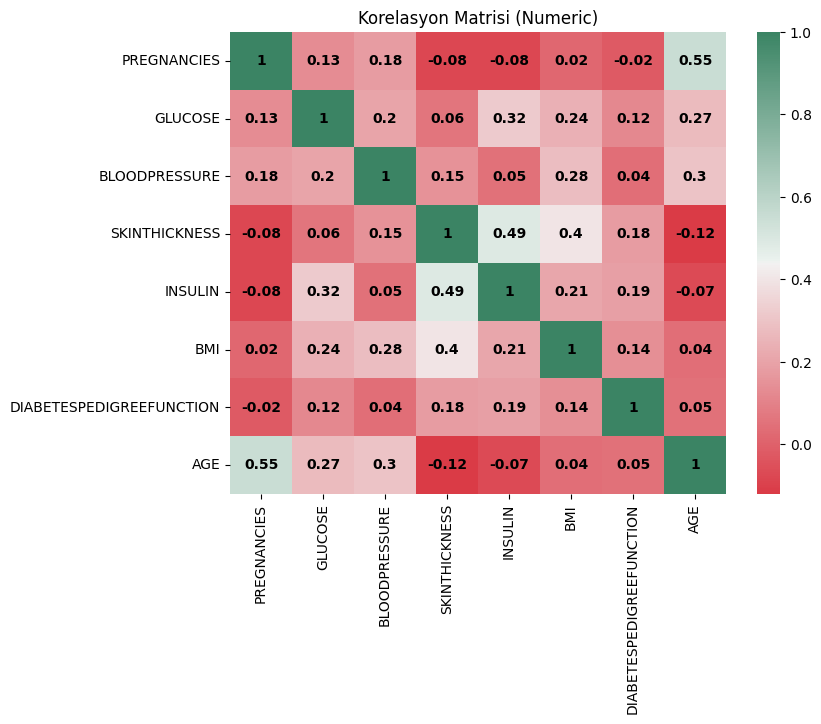

In [22]:
correlation_matrix = df[num_cols].corr().round(2)
plt.figure(figsize=(8, 6))
sns.heatmap(data=correlation_matrix, 
            annot=True, 
            annot_kws={"size": 10, "weight": "bold", "color": "black"}, 
            cmap=sns.diverging_palette(10, 150, as_cmap=True))


plt.title("Korelasyon Matrisi (Numeric)")
plt.xticks(rotation=90)
plt.show()

# 2. FEATURE ENGINNERING

## 2.1 '0' Olan Değerlerin 'NaN' dönüştürülmesi

In [23]:
# DataFrame'de derikalınlığı ve insulin sayıları 0 değerlerin 'NaN' ile değiştirilmesi.
df["SKINTHICKNESS"] = df["SKINTHICKNESS"].replace(0, np.nan)

In [24]:
# Insulin değerinin sütunundaki 0 olan değerleri 'NaN' ile boş doldurulması
df["INSULIN"] = df["INSULIN"].replace(0, np.nan)

In [25]:
missing_values_table(df)

               n_miss  ratio
INSULIN           374 48.700
SKINTHICKNESS     227 29.560


In [26]:
# Deri kalınlığı ve Insulin değişkenlerin 'NaN' olan değerlerin median ile doldurulması.
df['SKINTHICKNESS'].fillna(df['SKINTHICKNESS'].median(), inplace = True)
df['INSULIN'].fillna(df['INSULIN'].median(), inplace = True)

In [27]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## 2.2 Yeni değişkenlerin oluşturulması (ML'e katkı)

In [28]:
# 1. Age Group: Yaşların kategorize edilmesi (Young, Middle-Aged, Senior)
df['AgeGroup'] = pd.cut(df['AGE'], bins=[20, 30, 50, 100], labels=['Young', 'Middle-Aged', 'Senior'])

# 2. BMI Category: Vücut kitle oranı kategorize edilmesi (Underweight, Normal, Overweight, Obese)
df['BMICategory'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 3. Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["GLUCOSE"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

# 4. Glucose-Insulin Ratio: Calculate the ratio of glucose to insulin (handling cases with zero insulin)
df['GlucoseInsulinRatio'] = df['GLUCOSE'] / (df['INSULIN'].replace(0, 1))  # Replace zero insulin to avoid division by zero

# 5. Pregnancy-Age Interaction: Interaction between pregnancies and age
df['PregnancyAgeInteraction'] = df['PREGNANCIES'] * df['AGE']

# 6. High Blood Pressure Flag: Binary flag for high blood pressure (above 80 as an example threshold)
df['HighBloodPressureFlag'] = (df['BLOODPRESSURE'] > 80).astype(int)


# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["BMI"] < 18.5) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["AGE"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"


# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["GLUCOSE"] < 70) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["GLUCOSE"] < 70) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["GLUCOSE"] >= 70) & (df["GLUCOSE"] < 100)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["GLUCOSE"] >= 70) & (df["GLUCOSE"] < 100)) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["GLUCOSE"] >= 100) & (df["GLUCOSE"] <= 125)) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["GLUCOSE"] >= 100) & (df["GLUCOSE"] <= 125)) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["GLUCOSE"] > 125) & ((df["AGE"] >= 21) & (df["AGE"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["GLUCOSE"] > 125) & (df["AGE"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

In [29]:
# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="INSULIN"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"


df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)
df["NEW_GLUCOSE*INSULIN"] = df["GLUCOSE"] * df["INSULIN"]


# sıfır olan değerler dikkat!!!!
df["NEW_GLUCOSE*PREGNANCIES"] = df["GLUCOSE"] * df["PREGNANCIES"]

In [30]:
# Kolan harfleri büyütme
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGEGROUP,BMICATEGORY,NEW_GLUCOSE,GLUCOSEINSULINRATIO,PREGNANCYAGEINTERACTION,HIGHBLOODPRESSUREFLAG,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6.000,148.000,72,35.000,125.000,33.600,0.627,50.000,1,Middle-Aged,Obese,Prediabetes,1.184,300.000,0,obesesenior,highsenior,Normal,18500.000,888.000
1,1.000,85.000,66,29.000,125.000,26.600,0.351,31.000,0,Middle-Aged,Overweight,Normal,0.680,31.000,0,obesemature,normalmature,Normal,10625.000,85.000
2,8.000,183.000,64,29.000,125.000,23.300,0.672,32.000,1,Middle-Aged,Normal,Prediabetes,1.464,256.000,0,obesemature,highmature,Normal,22875.000,1464.000
3,1.000,89.000,66,23.000,94.000,28.100,0.167,21.000,0,Young,Overweight,Normal,0.947,21.000,0,obesemature,normalmature,Normal,8366.000,89.000
4,0.000,137.000,40,35.000,168.000,43.100,1.200,33.000,1,Middle-Aged,Obese,Normal,0.815,0.000,0,obesemature,highmature,Abnormal,23016.000,0.000


## 2.3 Encoding işlemler

In [31]:
cat_cols, num_cols, cat_but_car = grap_col_names(df)

Gözlemler: 768
Değişkenler: 20
Kategorik_Değişkenler: 8
Numerik_Değişkenler: 12
cat_but_car: 0
Numerik_görünümlük_Kategoriler: 5


In [32]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_INSULIN_SCORE']

In [33]:
#Kategoriler arasında yaşa göre bir sıralama olduğundan, Label Encoding bu değişken için daha uygun olacaktır.

def label_encoder(dataframe, binary_cols):
    label_encoder = LabelEncoder()
    dataframe[binary_cols] = label_encoder.fit_transform(dataframe[binary_cols])
    return dataframe

In [34]:
for col in binary_cols:
    df = label_encoder(df, col)

In [35]:
# One-Hot Encoding İşlemi

# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols



def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df = one_hot_encoder(df, cat_cols, drop_first=True)

In [36]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSEINSULINRATIO,PREGNANCYAGEINTERACTION,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_BMI_NOM_underweightsenior,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,AGEGROUP_Middle-Aged,AGEGROUP_Senior,BMICATEGORY_Normal,BMICATEGORY_Overweight,BMICATEGORY_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes,HIGHBLOODPRESSUREFLAG_1
0,6.000,148.000,72,35.000,125.000,33.600,0.627,50.000,1,1.184,300.000,1,18500.000,888.000,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False
1,1.000,85.000,66,29.000,125.000,26.600,0.351,31.000,0,0.680,31.000,1,10625.000,85.000,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False
2,8.000,183.000,64,29.000,125.000,23.300,0.672,32.000,1,1.464,256.000,1,22875.000,1464.000,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False
3,1.000,89.000,66,23.000,94.000,28.100,0.167,21.000,0,0.947,21.000,1,8366.000,89.000,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
4,0.000,137.000,40,35.000,168.000,43.100,1.200,33.000,1,0.815,0.000,0,23016.000,0.000,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False


## 2.4 Standart Scaler (Standartlaştırma)

In [37]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [38]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSEINSULINRATIO,PREGNANCYAGEINTERACTION,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_BMI_NOM_underweightsenior,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,AGEGROUP_Middle-Aged,AGEGROUP_Senior,BMICATEGORY_Normal,BMICATEGORY_Overweight,BMICATEGORY_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes,HIGHBLOODPRESSUREFLAG_1
0,0.647,0.862,0.093,0.687,-0.157,0.209,0.589,1.446,1,0.168,0.951,1,0.124,0.896,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False
1,-0.849,-1.159,-0.330,-0.010,-0.157,-0.784,-0.378,-0.189,0,-0.549,-0.741,1,-0.593,-0.860,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False
2,1.246,1.985,-0.471,-0.010,-0.157,-1.253,0.747,-0.103,1,0.566,0.675,1,0.523,2.155,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False
3,-0.849,-1.031,-0.330,-0.706,-0.668,-0.571,-1.023,-1.050,0,-0.170,-0.804,1,-0.799,-0.851,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
4,-1.148,0.509,-2.163,0.687,0.552,1.558,2.597,-0.017,1,-0.357,-0.936,0,0.536,-1.046,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False


In [39]:
df.shape

(768, 32)

# 3.MODEL KURULUMU

In [40]:
# Hedef değişken (target) ve özellikleri (features) ayırma
y = df['OUTCOME']  # Hedef değişken
X = df.drop('OUTCOME', axis=1) # Özellikler

In [41]:
# Eğitim ve test seti ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

## 3.1 Random Forest Modeli

In [42]:
# Random forest modeli oluşturma ve eğitme
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)



#Tahmin yapma ve sonuçları değerlendirme
y_pred_rf = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_rf), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred_rf), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred_rf), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred_rf), 2)}")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.79
Recall: 0.65
Precision: 0.72
F1: 0.68
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       150
           1       0.72      0.65      0.68        81

    accuracy                           0.79       231
   macro avg       0.77      0.76      0.76       231
weighted avg       0.78      0.79      0.79       231



In [43]:
def plot_importance(model, features, num = len(X), save = False):
    features_imp = pd.DataFrame({"Value": model.feature_importances_, 
                                 "Feature": features.columns})   
    plt.figure(figsize=(8, 6))
    
    sns.set(font_scale = 1)
    sns.barplot(x="Value", 
                y = "Feature", 
                data = features_imp.sort_values(by = "Value", ascending = False)[0:num])
    
    plt.title("Features")
    plt.tight_layout()
    plt.show()

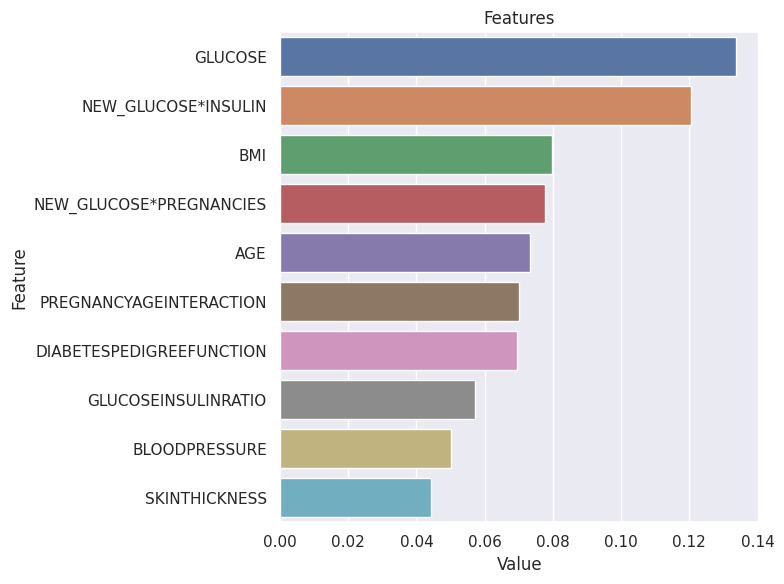

In [44]:
plot_importance(rf_model, X, 10)

## 3.2 Grandient Boosting Modeli

In [45]:
# Gradient Boosting Modeli
gb_model = GradientBoostingClassifier(random_state=46).fit(X_train, y_train)


# Tahmin apma ve sonuçları değerlendirme
y_pred_gb = gb_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_gb), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred_gb), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred_gb), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred_gb), 2)}")
print(classification_report(y_test, y_pred_gb))

Accuracy: 0.77
Recall: 0.65
Precision: 0.69
F1: 0.67
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       150
           1       0.69      0.65      0.67        81

    accuracy                           0.77       231
   macro avg       0.75      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231



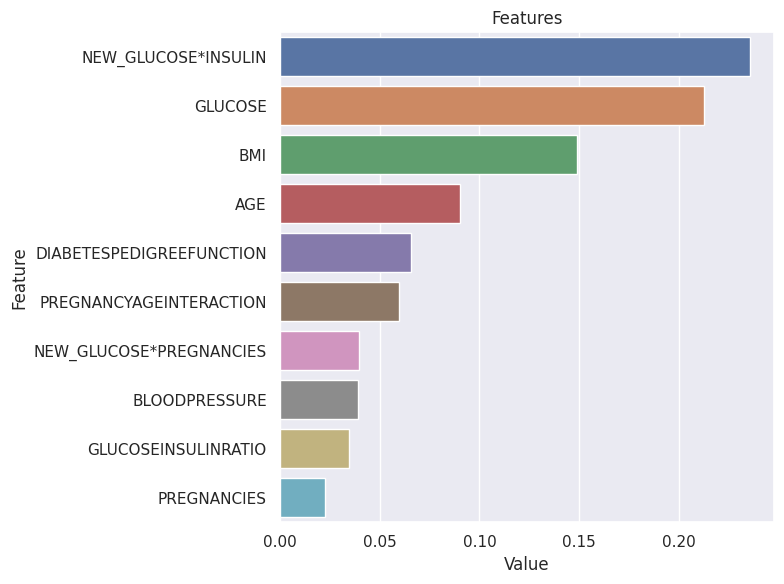

In [46]:
plot_importance(gb_model, X, 10)

## 3.3 XGBoost Modeli

In [47]:
# XGBoost Modeli oluşturma ve eğitme
xgb_model = XGBClassifier(random_state=46).fit(X_train, y_train)


# Tahmin yapma ve sonuçları değerlendirme
y_pred_xgb = xgb_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_xgb), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred_xgb), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred_xgb), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred_xgb), 2)}")
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.76
Recall: 0.6
Precision: 0.68
F1: 0.64
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       150
           1       0.68      0.60      0.64        81

    accuracy                           0.76       231
   macro avg       0.74      0.73      0.73       231
weighted avg       0.76      0.76      0.76       231



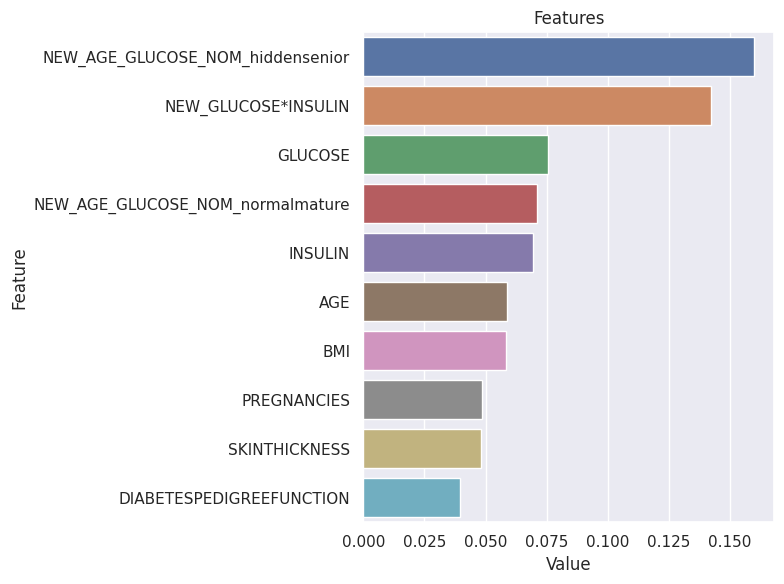

In [48]:
plot_importance(xgb_model, X, 10)

## 3.4 KNN Modeli

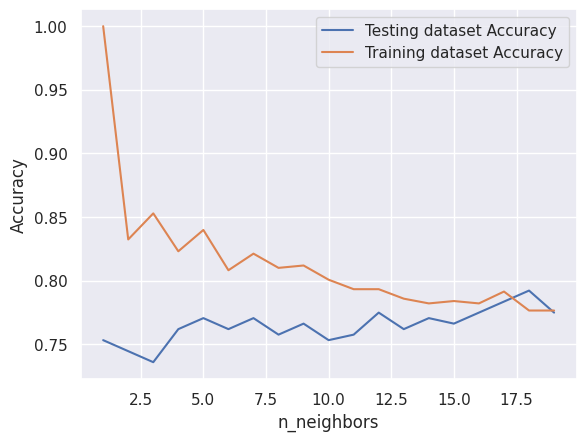

In [49]:
# En optimum KNN model seçimi

neighbors = np.arange(1, 20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    

# Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)


# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')


plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [50]:
# KNN modeli oluşturma ve eğitme
knn_model = KNeighborsClassifier(n_neighbors=18).fit(X_train, y_train)



# Tahmin yapma ve sonuçları değerlendirme
y_pred_knn = knn_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_knn), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred_knn), 2)}")
print(f"Precision: {round(precision_score(y_test, y_pred_knn), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred_knn), 2)}")
print(classification_report(y_test, y_pred_knn))


Accuracy: 0.79
Recall: 0.54
Precision: 0.8
F1: 0.65
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       150
           1       0.80      0.54      0.65        81

    accuracy                           0.79       231
   macro avg       0.79      0.73      0.75       231
weighted avg       0.79      0.79      0.78       231

